In [156]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import (
    Ridge,RidgeCV,
    Lasso,LassoCV,
    ElasticNet, ElasticNetCV,
    LinearRegression
)
from sklearn.model_selection import(
    cross_val_score,
    train_test_split
)
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures
)
from sklearn.feature_selection import SelectFromModel
pd.set_option('display.max_rows', 1000)  # or 1000
# pd.set_option('display.max_columns', 1000)  # or 1000

from itertools import combinations
from itertools import permutations

from sklearn.preprocessing import OneHotEncoder

## Project Outline

### Pre-processing 
### First pass - Linear regression
### Lasso and Ridge, compare Coefficients and drop. 
### Lasso - not interpretable need to reduce features 
### Conclusion and recommendations

## Import Data 

In [118]:
# read data 

df = pd.read_csv('temp.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)

In [119]:
df

,index,id,pid,ms_subclass,ms_zoning,lot_front,lot_area,street,alley,lot_shape,...,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,sale_type,sale_price,gr_liv_area_class,sale_price_classified
0,0,109,533352170,60,RL,69.0552,13517,Pave,NoAlley,IR1,...,0,0,0,0,0,3,WD,130500.0,0,0
1,1,544,531379050,60,RL,43.0000,11492,Pave,NoAlley,IR1,...,0,0,0,0,0,4,WD,220000.0,0,0
2,2,153,535304180,20,RL,68.0000,7922,Pave,NoAlley,Reg,...,0,0,0,0,0,1,WD,109000.0,0,0
3,3,318,916386060,60,RL,73.0000,9802,Pave,NoAlley,Reg,...,0,0,0,0,0,4,WD,174000.0,0,0
4,4,255,906425045,50,RL,82.0000,14235,Pave,NoAlley,IR1,...,0,0,0,0,0,3,WD,138500.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,873,1662,527377110,60,RL,80.0000,8000,Pave,NoAlley,Reg,...,0,0,0,0,0,11,WD,NaN,0,0
2925,874,1234,535126140,60,RL,90.0000,14670,Pave,NoAlley,Reg,...,0,0,0,0,0,8,WD,NaN,0,0
2926,875,1373,904100040,20,RL,55.0000,8250,Pave,NoAlley,Reg,...,0,0,0,0,0,8,WD,NaN,0,0
2927,876,1672,527425140,20,RL,60.0000,9000,Pave,NoAlley,Reg,...,0,0,0,0,0,5,WD,NaN,0,0


## Pre-processing 

#### Add weight on ordinal categories 

In [120]:
# declare ordinal category

ordinal_cat = ['lot_shape','util','land_slope','exter_qual','exter_cond','bsmt_qual','bsmt_cond','bsmt_exposure',
               'bsmtfin_type1','bsmt_type2','electrical','kitchen_qual','functional','fireplace_qu','garage_finish',
               'garage_qual','garage_cond','paved_drive','overall_cond','heating_qc'
]

In [121]:
# printing out all unique var in ordinal categories 
for cat in ordinal_cat:
    print(cat,df[cat].unique())

lot_shape ['IR1' 'Reg' 'IR2' 'IR3']
util ['AllPub' 'NoSeWa' 'NoSewr']
land_slope ['Gtl' 'Sev' 'Mod']
exter_qual ['Gd' 'TA' 'Ex' 'Fa']
exter_cond ['TA' 'Gd' 'Fa' 'Ex' 'Po']
bsmt_qual ['TA' 'Gd' 'Fa' 'NoBsmt' 'Ex' 'Po']
bsmt_cond ['TA' 'Gd' 'NoBsmt' 'Fa' 'Po' 'Ex']
bsmt_exposure ['No' 'Gd' 'Av' 'NoBsmt' 'Mn']
bsmtfin_type1 ['GLQ' 'Unf' 'ALQ' 'Rec' 'NoBsmt' 'BLQ' 'LwQ']
bsmt_type2 ['Unf' 'Rec' 'NoBsmt' 'BLQ' 'GLQ' 'LwQ' 'ALQ']
electrical ['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix']
kitchen_qual ['Gd' 'TA' 'Fa' 'Ex' 'Po']
functional ['Typ' 'Mod' 'Min2' 'Maj1' 'Min1' 'Sev' 'Sal' 'Maj2']
fireplace_qu ['NoFireplace' 'TA' 'Gd' 'Po' 'Ex' 'Fa']
garage_finish ['RFn' 'Unf' 'Fin' 'NoGarage']
garage_qual ['TA' 'Fa' 'NoGarage' 'Gd' 'Ex' 'Po']
garage_cond ['TA' 'Fa' 'NoGarage' 'Po' 'Gd' 'Ex']
paved_drive ['Y' 'N' 'P']
overall_cond [8 5 7 6 3 9 2 4 1]
heating_qc ['Ex' 'TA' 'Gd' 'Fa' 'Po']


In [122]:
# defining a function to return rate
def rate_Po_Excellent(col): 
    rate_dict = {'NoBsmt': 0,'NoFireplace': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5,
                 'Gtl':3, 'Sev':1, 'Mod':2,
                'IR1':3, 'Reg':4, 'IR2':2, 'IR3':1,
                'AllPub':3, 'NoSeWa':1, 'NoSewr':2,
                'No':1, 'Gd':4, 'Av':3, 'Mn':2,
                'NoGarage':0, 'Unf': 1, 'RFn': 2, 'Fin': 3,
                'SBrkr':5, 'FuseF':3,'FuseA':4, 'FuseP':2, 'Mix':1,
                'Typ':8, 'Mod':5, 'Min2':6, 'Maj1':4, 'Min1':7, 'Sev':2, 'Sal':1, 'Maj2':3,
                'Y':3, 'N':1, 'P':2,
                 'Unf':1 , 'Rec':3 , 'NoBsmt':0 , 'BLQ':4 , 'GLQ':6 , 'LwQ':2 , 'ALQ':5 ,
                }

    return rate_dict[col]

#### Assign scores to ordinal categories and assign get_dummies for categorical categories

In [123]:
# check if all ranked and sequential 
for cat in ordinal_cat:
    if cat != 'overall_cond':
        df[cat] = df[cat].map(rate_Po_Excellent)
        print(cat,df[cat].unique())
    else:
        print(cat,df[cat].unique())

lot_shape [3 4 2 1]
util [3 1 2]
land_slope [3 2 5]
exter_qual [4 3 5 2]
exter_cond [3 4 2 5 1]
bsmt_qual [3 4 2 0 5 1]
bsmt_cond [3 4 0 2 1 5]
bsmt_exposure [1 4 3 0 2]
bsmtfin_type1 [6 1 5 3 0 4 2]
bsmt_type2 [1 3 0 4 6 2 5]
electrical [5 3 4 2 1]
kitchen_qual [4 3 2 5 1]
functional [8 5 6 4 7 2 1 3]
fireplace_qu [0 3 4 1 5 2]
garage_finish [2 1 3 0]
garage_qual [3 2 0 4 5 1]
garage_cond [3 2 0 1 4 5]
paved_drive [3 1 2]
overall_cond [8 5 7 6 3 9 2 4 1]
heating_qc [5 3 4 2 1]


In [124]:
# Declare main variables consisting from chosen highly correlated variables  

main_variables = ['lot_front', 'lot_area', 'overall_qual', 'age', 'remod_age',
 'exter_qual', 'bsmt_qual', 'heating_qc', 'total_bsmt_sf', '1st_flr_sf', 'gr_liv_area',
 'kitchen_qual', 'garage_finish', 'fireplace_qu',
    'sale_price','garage_area','bsmtfin_sf1','tot_rms_abv_grd' ]

# Declare other columns as categorial features that needs to be dummified.
other_columns = [col for col in df.columns if (col not in main_variables) & (col not in ['index','id','pid']) & (col not in ordinal_cat)]


In [125]:
# Change other columns to get dummies for cat features

other_df = df.copy()[other_columns]

# to separate categorical and numerical features 
other_cat_features = [col for col in other_df.columns if df[col].dtype == 'O']

other_cat_features

['ms_zoning',
 'street',
 'alley',
 'land_contour',
 'lot_config',
 'neighborhood',
 'cond_1',
 'cond_2',
 'bldg_type',
 'house_style',
 'roof_style',
 'roof_matl',
 'ext_1st',
 'ext_2nd',
 'mas_vnr_type',
 'foundation',
 'heating',
 'central_air',
 'garage_type',
 'sale_type']

**Nominal feature selection**

|Feature|Feature name|Reason for inclusion|
|---|---|---|
|**Neighbourhood**|*neighborhood*|Different neighbourhoods may cost more hence need to consider| 
|**Roof Material**|*roof_matl*|Account for materials of roof| 
|**Condition 1**|*cond_1*|Proximity to main road or railroad needs to be added to account for values that may have impact to price eg. houses near main roads with Bus stops or near train stations will worth more in general| 
|**Condition 2**|*cond_2*|Proximity to main road or railroad needs to be added to account for values that may have impact to price eg. houses near main roads with Bus stops or near train stations will worth more in general| 
|**Building Type**|*bldg_type*|Type of dwelling need to consider as certain houses may cost more/less than the other types| 
|**Sale Type**|*sale_type*|Type of sale is important to consider, for example new home just constructed and sold would probably be eyed by buyers for its general condition assumed to be in top condition| 

In [126]:
# create column for nominal cat selection
col = ['neighborhood', 'roof_matl', 'cond_1', 'cond_2', 'bldg_type', 'sale_type']

norminal_cat = pd.get_dummies(data = other_df[col], drop_first = True)

In [166]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

def Union(lst1, lst2):
    empty = lst1.copy()
    for iter in len(lst2):
        if col not in intersection(lst1,lst2):
            empty.append(col)  
    return empty

# create df that 
main_data = pd.concat([df[Union(main_variables,ordinal_cat)],norminal_cat], axis = 1)

TypeError: 'int' object is not iterable

In [163]:
main_data['kitchen_qual']

,kitchen_qual,kitchen_qual
0,4,4
1,4,4
2,4,4
3,3,3
4,3,3
...,...,...
2924,3,3
2925,4,4
2926,3,3
2927,3,3


In [128]:
# # create df that 
# main_data = pd.concat([df[main_variables + ordinal_cat], other_df], axis =1)

In [129]:
# writing main_data and combi with other_df

id_adder = df['id']
main_data = pd.concat([id_adder,main_data], axis = 1)

#### Split Test and Train data 

In [130]:
# split test data (Kaggle)
# cross check -->> OK

kaggle_test_final = main_data[2051:]
kaggle_test_final = kaggle_test_final.reset_index(drop = 'index')
kaggle_test_final['sale_price']

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
873   NaN
874   NaN
875   NaN
876   NaN
877   NaN
Name: sale_price, Length: 878, dtype: float64

In [131]:
# split train data (Kaggle)

kaggle_train_final = main_data[:2051]
kaggle_train_final['sale_price'].tail(10)

2041    412500.0
2042     83000.0
2043    128000.0
2044    182000.0
2045    394617.0
2046    298751.0
2047     82500.0
2048    177000.0
2049    144000.0
2050    189000.0
Name: sale_price, dtype: float64

#### Apply Standard Scaler to train data

In [132]:
# assign X and y

X = kaggle_train_final.drop(columns = ['sale_price','id'])
y = kaggle_train_final['sale_price']
indices = X.index.values

# Create train/test splits.
X_train, X_test, y_train, y_test,indices_train, indices_test = train_test_split(
    X,
    y,
    indices,
    test_size=0.3,
    random_state = 123
)

# Scale our data.
# Relabeling scaled data as "Z" is common.
sc = StandardScaler()
# Z_train = sc.fit_transform(X_train)
sc.fit(X_train) # fit should only see train data, 
                #else if put in test, will have leak from the train data 
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

#### Instantiate model

In [133]:
lr = LinearRegression()

In [134]:
lasso = LassoCV(n_alphas=300)

In [135]:
ridge = RidgeCV(alphas=np.logspace(0, 5, 100))

## Model Selection

**Linear regression model**

In [136]:
#fit
lr.fit(X_train,y_train)

# cross val mse
cross_score = - cross_val_score(
    lr,
    X_train,
    y_train,
    cv = 3,
    scoring = 'neg_mean_squared_error'
).mean()

# test mse
mse_test = mean_squared_error(
    y_test,
    lr.predict(X_test)
)
# cross - test 
mse_train_minus_test = cross_score - mse_test

if mse_train_minus_test > 0:
    print(f'MSE for train: {cross_score}')
    print(f'MSE for test: {mse_test}')
    print(f'Underfited by: {mse_train_minus_test}')
else:
    print(f'MSE for train: {cross_score}')
    print(f'MSE for test: {mse_test}')
    print(f'Overfitted by: {mse_train_minus_test}')
print(f'RMSE: {mse_test**0.5}')

MSE for train: 4.2574830186417046e+30
MSE for test: 2.2026633511590502e+32
Overfitted by: -2.160088520972633e+32
RMSE: 1.4841372413490102e+16


**Lasso Regression**

In [137]:
# initiate 
lasso = LassoCV(
    cv=5,
    max_iter=50000,
    n_alphas=200,
)

# Fit model using best ridge alpha!
lasso.fit(X_train, y_train);


lasso.alpha_

319.7476670294984

In [138]:
lasso_best = Lasso(alpha = lasso.alpha_)

In [139]:
# fit lasso best 

lasso_best.fit(X_train,y_train)

Lasso(alpha=319.7476670294984)

In [140]:
# cross val mse
cross_score = - cross_val_score(
    lasso_best,
    X_train,
    y_train,
    cv = 3,
    scoring = 'neg_mean_squared_error'
).mean()

# test mse
mse_test = mean_squared_error(
    y_test,
    lasso_best.predict(X_test)
)
# cross - test 
mse_train_minus_test = cross_score - mse_test

if mse_train_minus_test > 0:
    print(f'MSE for train: {cross_score}')
    print(f'MSE for test: {mse_test}')
    print(f'Underfited by: {mse_train_minus_test}')
else:
    print(f'MSE for train: {cross_score}')
    print(f'MSE for test: {mse_test}')
    print(f'Overfitted by: {mse_train_minus_test}')
print(f'RMSE: {mse_test**0.5}')
print(f'Alpha used: {lasso_best.alpha}')

MSE for train: 853172825.0155439
MSE for test: 1000233127.0681939
Overfitted by: -147060302.05264997
RMSE: 31626.46244947724
Alpha used: 319.7476670294984


**Ridge Regression**

In [141]:
r_alphas = np.logspace(0, 5, 100)
ridge_cv = RidgeCV(alphas=r_alphas, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train, y_train);

ridge_best = Ridge(alpha = ridge_cv.alpha_)

ridge_best.fit(X_train,y_train)

# cross val mse
cross_score = - cross_val_score(
    ridge_best,
    X_train,
    y_train,
    cv = 3,
    scoring = 'neg_mean_squared_error'
).mean()

# test mse
mse_test = mean_squared_error(
    y_test,
    ridge_best.predict(X_test)
)
# cross - test 
mse_train_minus_test = cross_score - mse_test

if mse_train_minus_test > 0:
    print(f'MSE for train: {cross_score}')
    print(f'MSE for test: {mse_test}')
    print(f'Underfited by: {mse_train_minus_test}')
else:
    print(f'MSE for train: {cross_score}')
    print(f'MSE for test: {mse_test}')
    print(f'Overfitted by: {mse_train_minus_test}')
print(f'RMSE: {mse_test**0.5}')
print(f'Alpha used: {ridge_cv.alpha_}')

MSE for train: 849631104.5569156
MSE for test: 1007643701.659962
Overfitted by: -158012597.10304642
RMSE: 31743.404065411163
Alpha used: 65.79332246575679


## Model Choice

Linear regression model did not have a good score due to its high bias and variance due to its complexity after adding many features. Hence Linear regression model will not be used. 

For Lasso and Ridge, the RMSE is fairly competitive, with a RMSE of 31626 and 31743 respectively

Furthermore, both Lasso and Ridge are showing overfitting whereby the RMSE for train set is lower than the test set, hence not being able to generalise to unseen data. 

For this project, I will proceed feature engineering using **Lasso Regression** as I will need to use the model to remove negligible features with zero coefficients. 

**Found outlier and remove**

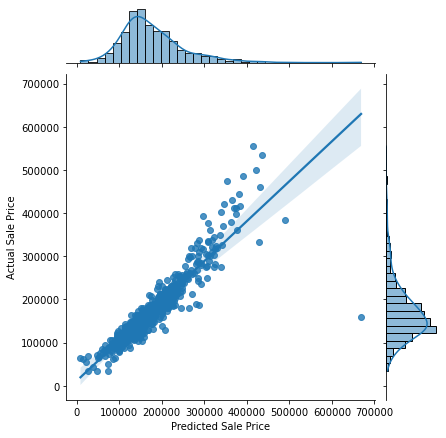

In [142]:
# noticed at higher ends of the sale_price,
# model is calculating below real sales_price

ax = sns.jointplot(
    x = lasso_best.predict(X_test),
    y = y_test,
    kind = 'reg'
)
ax.ax_joint.set_xlabel('Predicted Sale Price')
ax.ax_joint.set_ylabel('Actual Sale Price');

*Comments*

- observed skewing away from prediction model 
- starts from higher end sales price
- model is under predicting housing price 
- Need interaction terms to cater for the combined effect to effectively predict higher end sales price 


In [143]:
# find out index 339 having anomaly 
anomaly = [num for num,val in enumerate (lasso_best.predict(X_test)>500000) if val == True]
anomaly[0]

339

In [144]:
#index with anomoly
indices_test[anomaly[0]]

960

In [145]:
# putting sale price value of the index given

outlier_val = int(main_data.loc[main_data['sale_price'].index == indices_test[anomaly[0]], 'sale_price'].values)

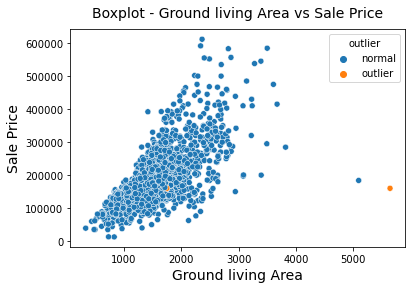

In [146]:
# copy to filter off outlier in scatterplot

filter_outlier = main_data.copy()

filter_outlier['outlier'] = filter_outlier['sale_price'].map(lambda x: 'outlier' if (x == outlier_val) else 'normal')

# found two outliers with one already found 

ax = sns.scatterplot(
    x = 'gr_liv_area',
    y = 'sale_price',
    data = filter_outlier,
    hue = 'outlier'
);

ax.set_title('Boxplot - Ground living Area vs Sale Price', fontdict={'fontsize': 14}, pad = 12)
ax.set_xlabel('Ground living Area', fontdict={'fontsize': 14})
ax.set_ylabel('Sale Price', fontdict={'fontsize': 14});


In [147]:
# found two outliers 
main_data[filter_outlier['gr_liv_area'] > 5000]

,id,lot_front,lot_area,overall_qual,age,remod_age,exter_qual,bsmt_qual,heating_qc,total_bsmt_sf,...,bldg_type_TwnhsE,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_VWD,sale_type_WD
960,1499,313.0,63887,10,0,0,5,5,5,6110.0,...,0,0,0,0,0,0,1,0,0,0
1885,2181,128.0,39290,10,-1,-2,5,5,5,5095.0,...,0,0,0,0,0,0,1,0,0,0


In [148]:
# drop two outliers from train data set 
main_data.drop(index = [960,1885], inplace = True)

**Redo train test split and fit into Lasso Best**

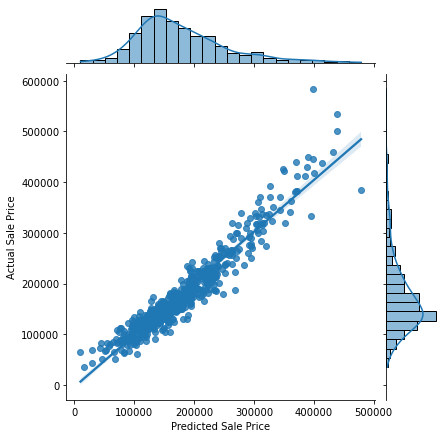

In [149]:
# split test data (Kaggle)
# cross check -->> OK

kaggle_test_final = main_data[2049:]
kaggle_test_final = kaggle_test_final.reset_index(drop = 'index')
kaggle_test_final['sale_price']

# split train data (Kaggle)

kaggle_train_final = main_data[:2049]
kaggle_train_final['sale_price'].tail(10)


# assign X and y

X = kaggle_train_final.drop(columns = ['sale_price','id'])
y = kaggle_train_final['sale_price']
indices = X.index.values

# Create train/test splits.
X_train, X_test, y_train, y_test,indices_train, indices_test = train_test_split(
    X,
    y,
    indices,
    test_size=0.3,
    random_state = 123
)

# Scale our data.
# Relabeling scaled data as "Z" is common.
sc = StandardScaler()
# Z_train = sc.fit_transform(X_train)
sc.fit(X_train) # fit should only see train data, 
                #else if put in test, will have leak from the train data 
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)


# initiate 
lasso = LassoCV(
    cv=5,
    max_iter=50000,
    n_alphas=200,
)

# Fit model using best ridge alpha!
lasso.fit(X_train, y_train);


lasso_best = Lasso(alpha = lasso.alpha_)

# fit lasso best 

lasso_best.fit(X_train,y_train)

# Redo jointplot to check on first pass Lasso model
ax = sns.jointplot(
    x = lasso_best.predict(X_test),
    y = y_test,
    kind = 'reg'
)
ax.ax_joint.set_xlabel('Predicted Sale Price')
ax.ax_joint.set_ylabel('Actual Sale Price');

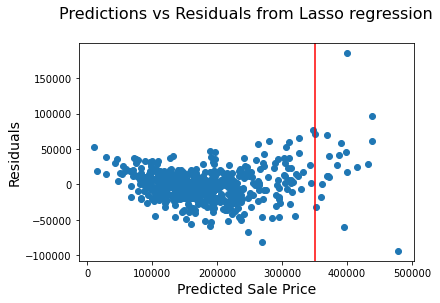

In [150]:
residuals = y_test - lasso_best.predict(X_test)
plt.scatter(lasso_best.predict(X_test), residuals)
plt.xlabel('Predicted Sale Price', fontdict={'fontsize': 14})
plt.ylabel('Residuals', fontdict={'fontsize': 14})
plt.title('Predictions vs Residuals from Lasso regression',  fontdict={'fontsize': 16}, pad = 25)
plt.axvline(x=350000, color = 'red');

After removing outlier, we faced problem where the Lasso regression tends to skew upwards away from the linear predicted line.

From the Predictions vs Residuals, we can see after $350K, residuals became larger with delta as close as above $150K

This indicates clear under-evaluation of housing price by the prediction model

**Hypothesis:** ***There is some missing X-factor that dampens the effect of the true value of such grand houses.***

## Add interaction terms

In [151]:
kaggle_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2050
Columns: 101 entries, id to sale_type_WD 
dtypes: float64(5), int64(34), uint8(62)
memory usage: 764.4 KB


In [152]:
kaggle_train_final['lot_area']**0.5 *\
kaggle_train_final['overall_qual']*kaggle_train_final['kitchen_qual']

TypeError: '<' not supported between instances of 'str' and 'int'

In [ ]:
# adding interaction terms based on EDA in first journal

kaggle_train_final['interaction_1'] = kaggle_train_final['lot_area']**0.5 *\
kaggle_train_final['overall_qual']*kaggle_train_final['kitchen_qual']*\
kaggle_train_final['exter_qual']* kaggle_train_final['bsmt_qual']* kaggle_train_final['heating_qc']*\
kaggle_train_final['total_bsmt_sf']**0.5 * kaggle_train_final['1st_flr_sf']**0.5 *kaggle_train_final['gr_liv_area']**0.5\
* kaggle_train_final['tot_rms_abv_grd']

# # plot regplot of interaction term against price
# ax = sns.regplot(
#     x = 'interaction_1',
#     y = 'sale_price',
#     data = kaggle_train_final
# )
# # set labels
# ax.set_title('Boxplot - Interaction term vs Sale Price', fontdict={'fontsize': 14}, pad = 12)
# ax.set_xlabel('Interaction term' , fontdict={'fontsize': 14})
# ax.set_ylabel('Sale Price', fontdict={'fontsize': 14});


TypeError: '<' not supported between instances of 'str' and 'int'

*comments*

- interaction term is highly correlated to sales price 
- High in magnitude 
- improved RMSE of 18% 

In [ ]:
# redo scale and lasso 
X_train, X_test, y_train, y_test, lasso_best= lasso_reg(
    X_df = kaggle_train_final.drop(columns = ['sale_price','id']),
    y_series = kaggle_train_final['sale_price'],
    test_size = 0.3
)

Lasso alpha used: 79.87589251414687
MSE for train: 532131286.33195156
MSE for test: 456955643.9232439
Underfited by: 75175642.40870768
RMSE: 21376.520856379877


In [ ]:
# Change in RMSE 

RMSE_before_interaction_term = 26174.885500285694
RMSE_after_interaction_term= 21376.52085637988

Difference = RMSE_after_interaction_term - RMSE_before_interaction_term
percent_dif = round(Difference/RMSE_before_interaction_term * 100, 2)
print(f'Current RMSE: {RMSE_after_interaction_term}')
print(f'Difference in RMSE: {Difference}')
print(f'Percentage diff: {percent_dif}%')

Current RMSE: 21376.52085637988
Difference in RMSE: -4798.364643905814
Percentage diff: -18.33%


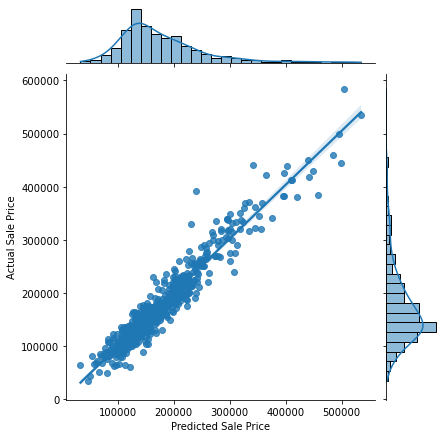

In [ ]:
# No more skewing from the higher end sale price 

ax = sns.jointplot(
    x = lasso_best.predict(X_test),
    y = y_test,
    kind = 'reg'
)
ax.ax_joint.set_xlabel('Predicted Sale Price')
ax.ax_joint.set_ylabel('Actual Sale Price');

**Need to consider other nominal categories for better fit**

In [ ]:
# read in csv that takes in all other columns 

main_data_other_col = pd.read_csv('Main_with_other_df.csv')
main_data_other_col.drop(columns = 'Unnamed: 0', inplace = True)
main_data_other_col.drop(columns = ['sale_price_classified'], inplace = True)

# drop these two columns as previously already dropped.
main_data_other_col.drop(index = [960,1885], inplace = True)

In [ ]:
# incorporate interaction term into data set 

main_data_other_col['interaction_1'] = main_data_other_col['lot_area']**0.5 *\
main_data_other_col['overall_qual']*main_data_other_col['kitchen_qual']*\
main_data_other_col['exter_qual']* main_data_other_col['bsmt_qual']* main_data_other_col['heating_qc']*\
main_data_other_col['total_bsmt_sf']**0.5 * main_data_other_col['1st_flr_sf']**0.5 *main_data_other_col['gr_liv_area']**0.5\
* main_data_other_col['tot_rms_abv_grd']

In [ ]:
# declare indexer 
indexer = main_data_other_col.shape[0] - len(main_data_other_col[pd.isnull(main_data_other_col['sale_price'])])
print(f'Indexer: {indexer}')

# split 
kaggle_test_final = main_data_other_col[indexer:]
kaggle_test_final = kaggle_test_final.reset_index(drop = 'index')
kaggle_test_final['sale_price']

Indexer: 2049


0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
873   NaN
874   NaN
875   NaN
876   NaN
877   NaN
Name: sale_price, Length: 878, dtype: float64

In [ ]:
# check
kaggle_train_final = main_data_other_col[:indexer]
kaggle_train_final['sale_price'].tail(10)

2041    412500.0
2042     83000.0
2043    128000.0
2044    182000.0
2045    394617.0
2046    298751.0
2047     82500.0
2048    177000.0
2049    144000.0
2050    189000.0
Name: sale_price, dtype: float64

In [ ]:
# assign X and y

X = kaggle_train_final.drop(columns = ['sale_price','id'])
y = kaggle_train_final['sale_price']
indices = X.index.values

# Create train/test splits.
X_train, X_test, y_train, y_test,indices_train, indices_test = train_test_split(
    X,
    y,
    indices,
    test_size=0.3,
    random_state = 123
)

# Scale our data.
# Relabeling scaled data as "Z" is common.
sc = StandardScaler()
# Z_train = sc.fit_transform(X_train)
sc.fit(X_train) # fit should only see train data, 
                #else if put in test, will have leak from the train data 
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

lr = LinearRegression()

lr.fit(X_train,y_train)

# cross val mse
cross_score = - cross_val_score(
    lr,
    X_train,
    y_train,
    cv = 3,
    scoring = 'neg_mean_squared_error'
).mean()

# test mse
mse_test_2 = mean_squared_error(
    y_test,
    lr.predict(X_test)
)
# cross - test 
mse_train_minus_test = cross_score - mse_test_2

if mse_train_minus_test > 0:
    print(f'MSE for train: {cross_score}')
    print(f'MSE for test: {mse_test_2}')
    print(f'Underfited by: {mse_train_minus_test}')
else:
    print(f'MSE for train: {cross_score}')
    print(f'MSE for test: {mse_test_2}')
    print(f'Overfitted by: {mse_train_minus_test}')
print(f'RMSE: {mse_test_2**0.5}')

MSE for train: 3.7806250227425617e+33
MSE for test: 5.696051876181163e+29
Underfited by: 3.780055417554944e+33
RMSE: 754721927346831.8


**When fitted with many variables, linear regression model has too much variance**
- Need to do Lasso regression for regularization purpose 


In [ ]:
# redo scale and lasso 
X_train, X_test, y_train, y_test, lasso_best= lasso_reg(
    X_df = kaggle_train_final.drop(columns = ['sale_price','id']),
    y_series = kaggle_train_final['sale_price'],
    test_size = 0.3
)

Lasso alpha used: 577.7130877096943
MSE for train: 504178963.4445021
MSE for test: 380940607.6126695
Underfited by: 123238355.83183259
RMSE: 19517.69985455944


In [ ]:
# Change in RMSE 

RMSE_before_col_added = 21376.52085637988
RMSE_after_col_added= 19517.699854559436

Difference = RMSE_after_col_added - RMSE_before_col_added
percent_dif = round(Difference/RMSE_before_col_added * 100, 2)
print(f'Current RMSE: {RMSE_after_col_added}')
print(f'Difference in RMSE: {Difference}')
print(f'Percentage diff: {percent_dif}%')

Current RMSE: 19517.699854559436
Difference in RMSE: -1858.8210018204445
Percentage diff: -8.7%


<AxesSubplot:>

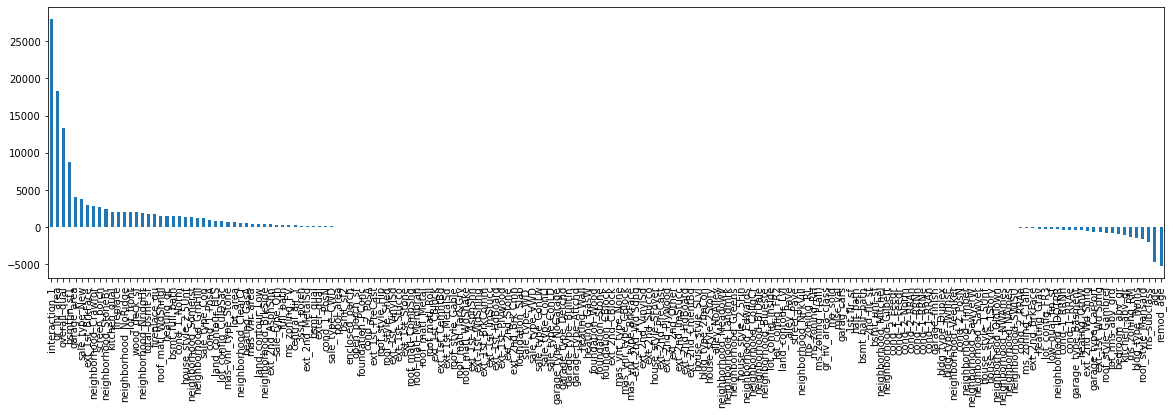

In [ ]:
# to plot the series 
# too many variables, need to scale down the number of features 
plt.figure(figsize=(20,5))

col = kaggle_train_final.columns.drop(['sale_price', 'id'])
pd.Series(lasso_best.coef_, index = col).sort_values(ascending = False).plot.bar()

**Optimise model**

In [ ]:
# fitting feature_set_model

feature_set_model = SelectFromModel(lasso_best)
feature_set_model.fit(X_train,y_train)

SelectFromModel(estimator=Lasso(alpha=577.7130877096943))

In [ ]:
# check boolean array of cofficients to be removed 
# this will be used for masking 
feature_set_model.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True, False,  True, False,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True, False, False, False,  True,  True, False, False, False,
        True, False, False, False,  True,  True, False,  True, False,
        True, False, False, False,  True,  True, False,  True, False,
       False, False,  True,  True, False, False, False,  True, False,
       False,  True,  True, False,  True, False, False,  True,  True,
       False, False, False,  True,  True,  True,  True, False, False,
        True, False, False,  True, False,  True, False, False, False,
       False,  True, False, False, False, False,  True, False, False,
       False, False,  True, False,  True, False, False, False, False,
       False, False, False,  True, False, False,  True, False, False,
       False, False,

In [ ]:
#refined model from 183 columns to 79 columns 

refined = list(kaggle_train_final.columns.drop(['sale_price','id'])[feature_set_model.get_support()])
len(refined)

79

In [ ]:
# redo scale and lasso 
# reduced by hundred. 
X_train, X_test, y_train, y_test, lasso_best= lasso_reg(
    X_df = kaggle_train_final.loc[:,refined],
    y_series = kaggle_train_final['sale_price'],
    test_size = 0.3
)

Lasso alpha used: 171.42494364032032
MSE for train: 469877795.49843717
MSE for test: 380150437.81336987
Underfited by: 89727357.6850673
RMSE: 19497.44695629071


Text(27.0, 0.5, 'Actual Sale Price')

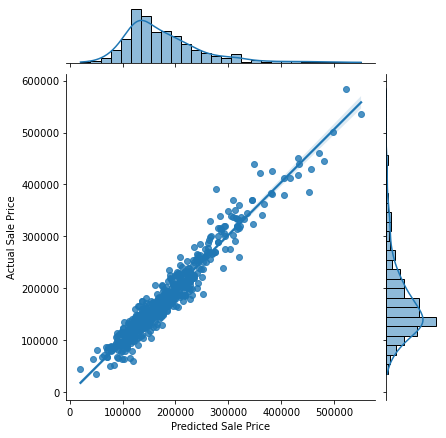

In [ ]:
# noticed at higher ends of the sale_price,
# model is calculating below real sales_price

ax2 = sns.jointplot(
    x = lasso_best.predict(X_test),
    y = y_test,
    kind = 'reg'
)
ax2.ax_joint.set_xlabel('Predicted Sale Price')
ax2.ax_joint.set_ylabel('Actual Sale Price')

**Hypothesis not all ordinal category should be ranked**

In [ ]:
# read in temporary df without columns edited yet 

df = pd.read_csv('temp.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)

In [ ]:
df

,index,id,pid,ms_subclass,ms_zoning,lot_front,lot_area,street,alley,lot_shape,...,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,sale_type,sale_price,gr_liv_area_class,sale_price_classified
0,0,109,533352170,60,RL,69.0552,13517,Pave,NoAlley,IR1,...,0,0,0,0,0,3,WD,130500.0,0,0
1,1,544,531379050,60,RL,43.0000,11492,Pave,NoAlley,IR1,...,0,0,0,0,0,4,WD,220000.0,0,0
2,2,153,535304180,20,RL,68.0000,7922,Pave,NoAlley,Reg,...,0,0,0,0,0,1,WD,109000.0,0,0
3,3,318,916386060,60,RL,73.0000,9802,Pave,NoAlley,Reg,...,0,0,0,0,0,4,WD,174000.0,0,0
4,4,255,906425045,50,RL,82.0000,14235,Pave,NoAlley,IR1,...,0,0,0,0,0,3,WD,138500.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,873,1662,527377110,60,RL,80.0000,8000,Pave,NoAlley,Reg,...,0,0,0,0,0,11,WD,NaN,0,0
2925,874,1234,535126140,60,RL,90.0000,14670,Pave,NoAlley,Reg,...,0,0,0,0,0,8,WD,NaN,0,0
2926,875,1373,904100040,20,RL,55.0000,8250,Pave,NoAlley,Reg,...,0,0,0,0,0,8,WD,NaN,0,0
2927,876,1672,527425140,20,RL,60.0000,9000,Pave,NoAlley,Reg,...,0,0,0,0,0,5,WD,NaN,0,0


In [ ]:
# defining a function to return rate
def rate_Po_Excellent(col): 
    rate_dict = {'NoBsmt': 0,'NoFireplace': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5,
                 'Gtl':3, 'Sev':1, 'Mod':2,
                'IR1':3, 'Reg':4, 'IR2':2, 'IR3':1,
                'AllPub':3, 'NoSeWa':1, 'NoSewr':2,
                'No':1, 'Gd':4, 'Av':3, 'Mn':2,
                'NoGarage':0, 'Unf': 1, 'RFn': 2, 'Fin': 3,
                'SBrkr':5, 'FuseF':3,'FuseA':4, 'FuseP':2, 'Mix':1,
                'Typ':8, 'Mod':5, 'Min2':6, 'Maj1':4, 'Min1':7, 'Sev':2, 'Sal':1, 'Maj2':3,
                'Y':3, 'N':1, 'P':2,
                 'Unf':1 , 'Rec':3 , 'NoBsmt':0 , 'BLQ':4 , 'GLQ':6 , 'LwQ':2 , 'ALQ':5 ,
                }

    return rate_dict[col]

In [ ]:
# declare main variables 

main_variables = ['lot_front', 'lot_area', 'overall_qual', 'age', 'remod_age',
 'exter_qual', 'bsmt_qual', 'heating_qc', 'total_bsmt_sf', '1st_flr_sf', 'gr_liv_area',
 'kitchen_qual', 'garage_finish', 'fireplace_qu',
    'sale_price','garage_area','bsmtfin_sf1','tot_rms_abv_grd' ]

# only categorise ordinally ranked for those that are in main_variables 
other_columns = [col for col in df.columns if (col not in main_variables) & (col not in ['index','id','pid','sale_price_classified'])]


In [ ]:
# less features are ranked 

for cat in main_variables:
    if df[cat].dtype == 'O':
        df[cat] = df[cat].map(rate_Po_Excellent)
        print(cat,df[cat].unique())

exter_qual [4 3 5 2]
bsmt_qual [3 4 2 0 5 1]
heating_qc [5 3 4 2 1]
kitchen_qual [4 3 2 5 1]
garage_finish [2 1 3 0]
fireplace_qu [0 3 4 1 5 2]


In [ ]:
# Change other columns to get dummies for cat features

other_df = df.copy()[other_columns]

other_cat_features = [col for col in other_df.columns if df[col].dtype == 'O']
other_numerical_features = [col for col in other_df.columns if df[col].dtype != 'O']


other_cat = pd.get_dummies(data = other_df[other_cat_features], drop_first = True)
other_num = other_df[other_numerical_features]

# creating another df for columns that are get_dummies
other_df = pd.concat([other_num,other_cat], axis = 1)
other_df

,ms_subclass,overall_cond,mas_vnr_area,bsmt_sf2,bsmt_unf_sf,2nd_flr_sf,low_qual_fin_sf,bsmt_full_bath,bsmt_half_bath,full_bath,...,paved_drive_Y,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_VWD,sale_type_WD
0,60,8,289.0,0.0,192.0,754,0,0.0,0.0,2,...,1,0,0,0,0,0,0,0,0,1
1,60,5,132.0,0.0,276.0,1209,0,1.0,0.0,2,...,1,0,0,0,0,0,0,0,0,1
2,20,7,0.0,0.0,326.0,0,0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,1
3,60,5,0.0,0.0,384.0,700,0,0.0,0.0,2,...,1,0,0,0,0,0,0,0,0,1
4,50,8,0.0,0.0,676.0,614,0,0.0,0.0,2,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,60,6,0.0,153.0,0.0,793,0,1.0,0.0,2,...,1,0,0,0,0,0,0,0,0,1
2925,60,7,410.0,0.0,529.0,884,0,0.0,0.0,2,...,1,0,0,0,0,0,0,0,0,1
2926,20,5,0.0,492.0,210.0,0,0,0.0,0.0,1,...,1,0,0,0,0,0,0,0,0,1
2927,20,6,0.0,0.0,248.0,0,0,0.0,0.0,1,...,1,0,0,0,0,0,0,0,0,1


In [ ]:
# combining df to be exported out 

id_adder = df['id']

df_main = df[main_variables]
df_main = pd.concat([id_adder,df_main], axis = 1)

df_main_refined = pd.concat([df_main,other_df], axis = 1)

In [ ]:
df_main_refined

,id,lot_front,lot_area,overall_qual,age,remod_age,exter_qual,bsmt_qual,heating_qc,total_bsmt_sf,...,paved_drive_Y,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_VWD,sale_type_WD
0,109,69.0552,13517,6,34,5,4,3,5,725.0,...,1,0,0,0,0,0,0,0,0,1
1,544,43.0000,11492,7,13,12,4,4,5,913.0,...,1,0,0,0,0,0,0,0,0,1
2,153,68.0000,7922,5,57,3,3,3,3,1057.0,...,1,0,0,0,0,0,0,0,0,1
3,318,73.0000,9802,5,4,3,3,4,4,384.0,...,1,0,0,0,0,0,0,0,0,1
4,255,82.0000,14235,6,110,17,3,2,3,676.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,1662,80.0000,8000,6,33,33,3,3,3,1084.0,...,1,0,0,0,0,0,0,0,0,1
2925,1234,90.0000,14670,6,42,9,4,3,5,1104.0,...,1,0,0,0,0,0,0,0,0,1
2926,1373,55.0000,8250,5,40,40,3,3,5,952.0,...,1,0,0,0,0,0,0,0,0,1
2927,1672,60.0000,9000,4,36,36,3,3,3,864.0,...,1,0,0,0,0,0,0,0,0,1


In [ ]:
# inserting interaction term
df_main_refined['interaction_1'] = df_main_refined['lot_area']**0.5 *\
df_main_refined['overall_qual']*df_main_refined['kitchen_qual']*\
df_main_refined['exter_qual']* df_main_refined['bsmt_qual']* df_main_refined['heating_qc']*\
df_main_refined['total_bsmt_sf']**0.5 * df_main_refined['1st_flr_sf']**0.5 *df_main_refined['gr_liv_area']**0.5\
* df_main_refined['tot_rms_abv_grd']

In [ ]:
#create df_main_refined file for final journal 
df_main_refined.to_csv('main_refined.csv')